In [1]:
import importlib

import pandas as pd
from IPython.display import display

import warnings

import Semantic_Maningfullness

warnings.filterwarnings('ignore')

from carla.data.causal_model import CausalModel

/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [2]:
import pandas as pd

# generate data
scm = CausalModel("sanity-3-lin")
dataset = scm.generate_dataset(10000)

# save data
# dataset.df.to_csv('generate_dataset.csv')

display(dataset.df)

,label,x1,x2,x3
0,1.0,-2.602391,4.478373,0.829049
1,1.0,2.126504,-1.757014,0.602956
2,0.0,0.068218,-0.203534,0.677179
3,1.0,-2.907360,2.774368,0.471105
4,0.0,1.232635,-2.489479,-3.618893
...,...,...,...,...
9995,0.0,-1.074881,1.637155,-0.530820
9996,0.0,-0.676496,0.532050,-0.227643
9997,1.0,1.782122,-1.500868,0.456745
9998,0.0,-1.513972,1.434621,0.384589


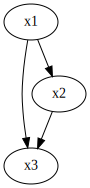

In [12]:
#Visualize the model
scm.cgm.draw()

In [5]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)



balance on test set 0.5186666666666667, balance on test set 0.54
Epoch 0/9
----------
train Loss: 0.3742 Acc: 0.8321

test Loss: 0.3473 Acc: 0.8400

Epoch 1/9
----------
train Loss: 0.3588 Acc: 0.8409

test Loss: 0.3645 Acc: 0.8416

Epoch 2/9
----------
train Loss: 0.3590 Acc: 0.8405

test Loss: 0.3563 Acc: 0.8464

Epoch 3/9
----------
train Loss: 0.3581 Acc: 0.8423

test Loss: 0.3556 Acc: 0.8416

Epoch 4/9
----------
train Loss: 0.3564 Acc: 0.8412

test Loss: 0.3589 Acc: 0.8456

Epoch 5/9
----------
train Loss: 0.3563 Acc: 0.8401

test Loss: 0.3568 Acc: 0.8460

Epoch 6/9
----------
train Loss: 0.3555 Acc: 0.8432

test Loss: 0.3523 Acc: 0.8420

Epoch 7/9
----------
train Loss: 0.3572 Acc: 0.8405

test Loss: 0.3511 Acc: 0.8424

Epoch 8/9
----------
train Loss: 0.3556 Acc: 0.8419

test Loss: 0.3472 Acc: 0.8452

Epoch 9/9
----------
train Loss: 0.3552 Acc: 0.8413

test Loss: 0.3499 Acc: 0.8384



In [6]:
from carla.models.negative_instances import predict_negative_instances
# get factuals
factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:10].reset_index(drop=True)

print(test_factual)

   label        x1        x2        x3
0    0.0  1.232635 -2.489479 -3.618893
1    0.0  2.164558 -2.350129 -1.593560
2    0.0  1.977212 -1.920549 -2.286081
3    0.0 -0.169518 -0.814678 -1.511378
4    0.0 -1.226388  0.645858 -0.372960
5    0.0 -1.720230  1.516265 -0.700344
6    0.0 -0.006033 -2.360816 -1.713630
7    0.0 -0.949089  0.120840  0.595354
8    1.0 -0.342294 -0.163795  0.293886
9    0.0  0.500473  0.498273 -1.199244


In [7]:
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}

# structural counterfactual (SCF)
cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)

output = cfs.reset_index(drop=True) - test_factual.loc[:,~test_factual.columns.isin(['label'])].reset_index(drop=True)
display(output)
display(cfs)

,x1,x2,x3
0,2.82888,0.47718,-2.45798
1,0.00000,0.47718,0.00000
2,0.00000,0.47718,0.00000
3,0.43862,0.47718,-0.69103
4,0.43862,0.47718,0.00000
5,0.00000,3.55204,0.00000
6,0.43862,0.47718,-0.69103
7,0.00000,0.47718,0.00000
8,0.00000,0.47718,0.00000
9,0.00000,0.00000,-0.69103


,x1,x2,x3
0,4.061515,-2.012299,-6.076873
1,2.164558,-1.872949,-1.593560
2,1.977212,-1.443369,-2.286081
3,0.269102,-0.337498,-2.202408
4,-0.787768,1.123038,-0.372960
5,-1.720230,5.068305,-0.700344
6,0.432587,-1.883636,-2.404660
7,-0.949089,0.598020,0.595354
8,-0.342294,0.313385,0.293886
9,0.500473,0.498273,-1.890274


In [8]:
import numpy as np
import importlib
from Semantic_Maningfullness import Sematic
importlib.reload(Semantic_Maningfullness)

mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
      'u3': 'x3',
      }
results=[]
i=0

test_factual = test_factual.loc[:,~test_factual.columns.isin(['label'])]

for a in test_factual.index:

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem=Sematic(ml_model,scm,mapping_dict)
        try:
            res=sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0]
            results.append( res)
        except: 
            pass
    i=i+1


cflabel [[2.7398416e-06]]
factuals_label [[3.4133516e-06]]
threshold [[0.36699255]]
predictions [[0.07585818]]
cflabel [[0.01935816]]
factuals_label [[0.00601843]]
threshold [[0.66406094]]
predictions [[0.07585818]]
cflabel [[0.00643541]]
factuals_label [[0.00196662]]
threshold [[0.66148472]]
predictions [[0.07585818]]
cflabel [[0.00567249]]
factuals_label [[0.00491599]]
threshold [[0.43093894]]
predictions [[0.07585818]]
cflabel [[0.4770396]]
factuals_label [[0.14076127]]
threshold [[0.50066279]]
predictions [[0.92414182]]
cflabel [[0.9735919]]
factuals_label [[0.14463776]]
threshold [[0.54900253]]
predictions [[0.92414182]]
cflabel [[9.322252e-05]]
factuals_label [[7.84637e-05]]
threshold [[0.90159868]]
predictions [[0.07585818]]
cflabel [[0.63190156]]
factuals_label [[0.40276557]]
threshold [[0.74530895]]
predictions [[0.92414182]]
cflabel [[0.6430698]]
factuals_label [[0.43143156]]
threshold [[0.51872931]]
predictions [[0.92414182]]
cflabel [[0.11891536]]
factuals_label [[0.3851874

In [9]:
# Averaging of the reults
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.8 +/- 0.4


In [10]:
#TODO This is currently not workin 
# Building Probability Distribution of the output divided into complient/ not complient
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs.iloc[id_comp[0]]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)
cfs_not_complient=cfs.iloc[id_not_comp[0]]

print(cfs_not_complient)


# cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)


(array([4, 7]),)
         x1        x2        x3
4 -0.787768  1.123038 -0.372960
7 -0.949089  0.598020  0.595354


In [11]:
#BoxPlot
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()

NameError: name 'cfs_not_complient_predict' is not defined